In [1]:
import argparse
import collections
import itertools
import math
import shlex
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import egg
from egg.zoo.basic_games.data_readers import AttrValClassDataset
from egg.zoo.basic_games import play_sum

In [2]:
PATH_TRAIN = "../../data/sum50.train.train"
PATH_VAL = "../../data/sum50.train.val"
PATH_TEST = "../../data/sum50.test"

In [3]:
def entropy(x_samples):
    n = len(x_samples)
    cx = collections.Counter(x_samples)
    return -sum([cx[x] / n * np.log2(cx[x] / n) for x in cx])

def cond_entropy(y_samples, x_samples):
    assert len(x_samples) == len(y_samples)
    n = len(x_samples)
    cx = collections.Counter(x_samples)
    cxy = collections.Counter(zip(x_samples, y_samples))
    return -sum([cxy[x, y] / n * np.log2(cxy[x, y] / cx[x]) for x, y in cxy])

def pointwise_mutual_information(x_samples, y_samples):
    assert len(x_samples) == len(y_samples)
    n = len(x_samples)
    cx = collections.Counter(x_samples)
    cy = collections.Counter(y_samples)
    cxy = collections.Counter(zip(x_samples, y_samples))
    return np.array([np.log2(cxy[x, y] * n / (cx[x] * cy[y])) for x, y in zip(x_samples, y_samples)])

def mutual_information(x_samples, y_samples):
    return pointwise_mutual_information(x_samples, y_samples).mean()

In [4]:
def update_legend(ax, **kwargs):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    if "title" not in kwargs:
        kwargs["title"] = old_legend.get_title().get_text()
    ax.legend(handles, labels, **kwargs)

In [63]:
exp_dir = "20210725-003558"

with open(Path(exp_dir) / "args") as f:
    args = shlex.split(f.read())
opts = play_sum.get_params(args)

# Make the trainer load the checkpoint instead of writing it
assert opts.checkpoint_dir
opts.load_from_checkpoint = str(Path(opts.checkpoint_dir) / "final.tar")
opts.checkpoint_dir = None
opts.tensorboard = False

game = play_sum.main(None, opts=opts, train=False)
game.eval()

Namespace(batch_size=32, checkpoint_dir=None, checkpoint_freq=0, cuda=True, device=device(type='cuda'), distributed_context=DistributedContext(is_distributed=False, rank=0, local_rank=0, world_size=1, mode='none'), distributed_port=18363, fp16=False, load_from_checkpoint='20210725-003558/final.tar', lr=0.001, max_len=4, mode='rf', n_attributes=None, n_epochs=500, n_values=50, no_cuda=False, optimizer='adam', preemptable=False, print_validation_events=False, random_seed=1123328456, receiver_cell='gru', receiver_embedding=50, receiver_hidden=100, receiver_layers=1, rnn=True, sender_cell='gru', sender_embedding=50, sender_entropy_coeff=0.1, sender_hidden=100, sender_layers=1, temperature=1.0, tensorboard=False, tensorboard_dir='20210725-003558', train_data='../../data/sum50.train.train', update_freq=1, validation_batch_size=32, validation_data='../../data/sum50.train.val', validation_freq=20, vocab_size=20)
# Initializing model, trainer, and optimizer from 20210725-003558/final.tar
# load

SenderReceiverRnnReinforce(
  (sender): RnnSenderReinforce(
    (agent): SumSender(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
      )
    )
    (hidden_to_output): Linear(in_features=100, out_features=20, bias=True)
    (embedding): Embedding(20, 50)
    (cells): ModuleList(
      (0): GRUCell(50, 100)
    )
  )
  (receiver): RnnReceiverDeterministic(
    (agent): SumReceiver(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=99, bias=True)
      )
    )
    (encoder): RnnEncoder(
      (cell): GRU(50, 100, batch_first=True)
      (embedding): Embedding(20, 50)
    )
  )
  (mechanics): CommunicationRnnReinforce()
)

In [64]:
data_loader = torch.utils.data.DataLoader(
    AttrValClassDataset(
        path=PATH_TRAIN,
        n_values=opts.n_values,
    ),
    batch_size=opts.validation_batch_size,
    shuffle=False,
    num_workers=1,
)

In [65]:
interaction = []
for sender_input, labels in data_loader:
    with torch.no_grad():
        interaction.append(game(sender_input.cuda(), labels.cuda())[1].to("cpu"))
interaction = egg.core.Interaction.from_iterable(interaction)

In [66]:
aa = interaction.sender_input[:, :opts.n_values].argmax(dim=-1).numpy()
bb = interaction.sender_input[:, opts.n_values:].argmax(dim=-1).numpy()
rr = interaction.receiver_output.argmax(dim=-1).numpy()
num_res = rr.max() + 1
correct_mask = (aa + bb == rr)

In [67]:
# Build a codebook of letter combinations to display instead of numbers for easier viewing
codewords = [''.join(l) for l in itertools.product(*[[chr(i) for i in range(ord('a'), ord('z') + 1)]] * math.ceil(math.log(opts.vocab_size, 26)))]
np.random.default_rng(1).shuffle(codewords)

In [68]:
messages = np.array([
    ''.join(codewords[i] for i in msg[:opts.max_len]) if isinstance(msg, list) else codewords[msg]
    for msg in interaction.message.tolist()])

In [69]:
all_df = pd.DataFrame({
    "msg": messages,
    "a": aa,
    "b": bb,
    "r": rr,
    "acc": aa + bb == rr,
    "ab": list(zip(aa, bb)),
    "ab_unordered": [tuple(sorted(x)) for x in zip(aa, bb)]}
)
correct_df = all_df[correct_mask]

In [70]:
print("Vocabulary size:", len(set(sym for msg in interaction.message[correct_mask].tolist() for sym in msg)))
print("Number of unique messages:", len(set(correct_df["msg"])))
print("Number of unique input pairs:", len(set(correct_df["ab"])))
print("Number of unique outputs:", len(set(correct_df["r"])))

Vocabulary size: 20
Number of unique messages: 502
Number of unique input pairs: 1801
Number of unique outputs: 98


In [71]:
# Normalized excess information
cond_entropy(correct_df["msg"], correct_df["r"]) / cond_entropy(correct_df["ab"], correct_df["r"])

0.3817901296452825

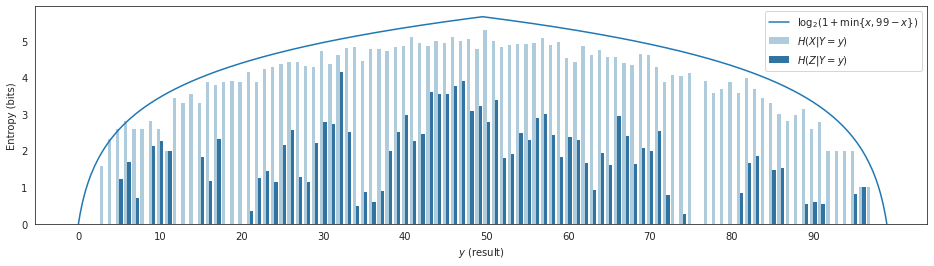

In [72]:
plt.figure(figsize=(16, 4))

# Empirical entropies
df = pd.DataFrame({
    "r": np.arange(num_res),
    "$H(X|Y=y)$": [entropy(correct_df[correct_df["r"] == r]["ab"]) for r in range(num_res)],
    "$H(Z|Y=y)$": [entropy(correct_df[correct_df["r"] == r]["msg"]) for r in range(num_res)]
}).melt(id_vars="r")
sns.set_style("white")
sns.barplot(data=df, x="r", y="value", hue="variable", dodge=True, palette="Paired", lw=0, ci=None)

# Theoretical entropy
r = np.linspace(0., num_res, 501)
sns.lineplot(x=r, y=np.log2(1 + np.minimum(r, num_res - r)),
             label="$\log_2(1+\min\{x," + str(num_res) + "-x\})$")

plt.xticks(plt.gca().get_xticks()[::10])
plt.xlabel("$y$ (result)")
plt.ylabel("Entropy (bits)")
plt.legend(title=None)
plt.savefig("figs/sum50_class_entropies.pdf", bbox_inches="tight")
plt.show()

In [73]:
# Commutative property
comm_df = correct_df.copy()
# Keep only pairs that are in the dataset both ways
ab_set = set(comm_df["ab"].values)
comm_df = comm_df[comm_df.apply(lambda row: tuple(reversed(row["ab"])) in ab_set, axis=1)]
comm_df = comm_df[["a", "b", "r", "msg"]].drop_duplicates()
comm_df = comm_df.groupby(["a", "b"]).first()
comm_df = comm_df.sort_values(["a", "b"])
comm_df["msg_ba"] = comm_df.reset_index().rename(columns={"a": "b", "b": "a"}).set_index(["a", "b"])["msg"]
comm_df["comm"] = (comm_df["msg"] == comm_df["msg_ba"])
comm_df = comm_df.reset_index()
comm_df = comm_df[comm_df["a"] < comm_df["b"]]  # Count each pair only once

print("Commutativity:", comm_df["comm"].mean())
print("Min. number of commutative pairs per sum:", comm_df.groupby("r")["comm"].count().min())

Commutativity: 0.5434782608695652
Min. number of commutative pairs per sum: 1


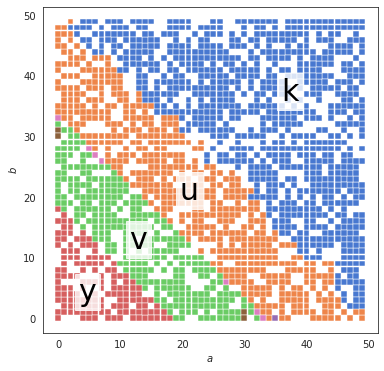

In [74]:
plt.figure(figsize=(6, 6))
df = correct_df.copy()
df["hue"] = df["msg"].str[:1]
sns.scatterplot(data=df.drop_duplicates(), x="a", y="b", hue="hue",
                palette="muted", marker="s", s=35, legend=False)
for label, a_mean, _, b_mean, count in df[["hue", "a", "b"]].groupby("hue").agg(["mean", "count"]).itertuples():
    if count > len(df) / num_res:
        plt.text(a_mean, b_mean, label, fontsize=30, ha="center", va="center",
                 color="black", backgroundcolor=(1, 1, 1, 0.8))
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.savefig("figs/sum50_symbol1_matrix.pdf")
plt.show()

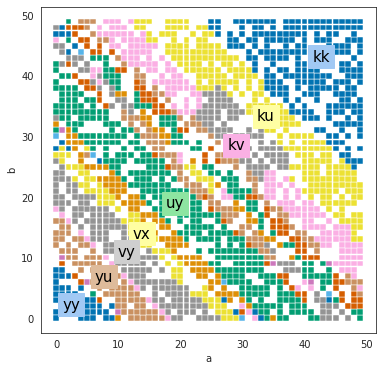

In [75]:
plt.figure(figsize=(6, 6))
df = correct_df.copy()
df["hue"] = df["msg"].str[:2]
r_sorted = df.groupby("hue")["r"].agg(["median", "count"]).sort_values("median")
sns.scatterplot(data=df.drop_duplicates(), x="a", y="b", hue="hue", hue_order=r_sorted.index,
                palette="colorblind", marker="s", s=35, legend=False)
palette = sns.color_palette("pastel")
for label, a_mean, _, b_mean, count in df[["hue", "a", "b"]].groupby("hue").agg(["mean", "count"]).itertuples():
    if count > len(df) / len(r_sorted) * 1.4:
        plt.text(a_mean, b_mean, label, fontsize=15, ha="center", va="center",
                 color="black", backgroundcolor=palette[list(r_sorted.index).index(label) % len(palette)])
plt.savefig("figs/sum50_symbol12_matrix.pdf")
plt.show()

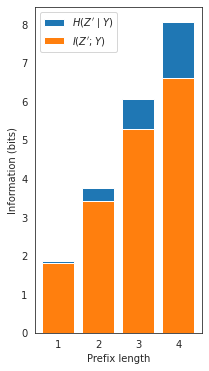

In [76]:
mi_prefix_r = [mutual_information(correct_df["msg"].str[:i], correct_df["r"]) for i in range(1, 5)]

plt.figure(figsize=(3, 6))
plt.bar(
    range(1, 5),
    [cond_entropy(correct_df["msg"].str[:i], correct_df["r"])
     for i in range(1, 5)],
    bottom=mi_prefix_r,
    label="$H(Z'\mid Y)$")
plt.bar(
    range(1, 5),
    mi_prefix_r,
    label="$I(Z'; Y)$")
plt.legend()
plt.xticks(range(1, 5))
plt.xlabel("Prefix length")
plt.ylabel("Information (bits)")
plt.savefig("figs/sum50_mi_prefix.pdf")
plt.show()

In [77]:
pd.concat([correct_df["msg"].str[i].value_counts() for i in range(4)], axis=1)

,msg,msg,msg,msg
k,22678.0,12868.0,3957.0,1424.0
y,9395.0,14277.0,14372.0,8082.0
u,8265.0,8882.0,4899.0,4098.0
v,7090.0,4600.0,1561.0,1163.0
z,123.0,443.0,2913.0,1447.0
a,80.0,NaN,NaN,95.0
b,25.0,NaN,NaN,NaN
x,NaN,3057.0,7888.0,9103.0
i,NaN,1258.0,18.0,NaN
l,NaN,841.0,1044.0,2863.0
